# Supercompressible: regression 3d (energy absorbed)

This notebook intends to show the application of neural networks to make predictions about the energy absorbed in the supercompressible example. In particular, the 3d case will be considered.

So, let's start by importing the required libraries:

In [1]:
# standard library
import pickle

# third-party
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense
from keras.callbacks import EarlyStopping

Now, let's import the data.

In [2]:
# get pandas frame
filename = 'DoE_results.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)
points = data['points']
print('variables:', [col for col in points.columns])

# get number of inputs
n_inputs = len(points.columns) - 3

# get X data
X = points.iloc[:,range(n_inputs)].values

# get y data
var_name = 'energy'
y = points.loc[:, var_name].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

variables: ['ratio_d', 'ratio_pitch', 'ratio_top_diameter', 'coilable', 'sigma_crit', 'energy']
X: [[0.004      0.25       0.        ]
 [0.0385     0.875      0.4       ]
 [0.05575    0.5625     0.2       ]
 ...
 [0.06037836 1.08930969 0.58618164]
 [0.04312836 0.77680969 0.38618164]
 [0.00862836 1.40180969 0.78618164]]
X shape: (10000, 3)
y: [2.79529996e-04            nan 1.42853201e+01 ...            nan
            nan            nan]
y shape: (10000,)


The variables ```X``` and ```y``` contain all the data. Nevertheless, there's ```NaN``` values that cannot be considered.

In [3]:
# missing indices
indices = pd.notnull(points.loc[:, var_name]).values

# get y data
y = points.loc[indices, var_name].values

# get X data
X = points.iloc[indices,range(n_inputs)].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

X: [[0.004      0.25       0.        ]
 [0.05575    0.5625     0.2       ]
 [0.0686875  0.328125   0.55      ]
 ...
 [0.06900336 0.30805969 0.68618164]
 [0.03450336 0.93305969 0.28618164]
 [0.02587836 0.46430969 0.18618164]]
X shape: (5264, 3)
y: [2.79529996e-04 1.42853201e+01 3.99711660e+01 ... 5.35333775e+01
 2.35352031e+00 6.15239445e-01]
y shape: (5264,)


Let's now clean the data.

In [4]:
def perform_cleaning(X, y, n_std_cleaning):
    
    # compute threshold
    y_mean, y_std = np.mean(y), np.std(y)
    y_thresh = y_mean + n_std_cleaning * y_std

    # indices
    print(y_thresh)
    indices = np.where(y < y_thresh)
    n_dismissed_points = len(y) - len(indices[0])
    print('Dismissed points:', n_dismissed_points)

    # X and y
    y = y[indices]
    X = X[indices]
    print(np.shape(y))
    print(np.shape(X))

    return X, y, n_dismissed_points

In [5]:
n_std_cleaning = 5  # dismiss points that fall outside this range

n_dismissed_points = 1
while n_dismissed_points > 0:
    X, y, n_dismissed_points = perform_cleaning(X, y, n_std_cleaning)

251.41209785647746
Dismissed points: 6
(5258,)
(5258, 3)
78.83845527943124
Dismissed points: 7
(5251,)
(5251, 3)
76.83459344264611
Dismissed points: 0
(5251,)
(5251, 3)


Text(0, 0.5, 'Frequency')

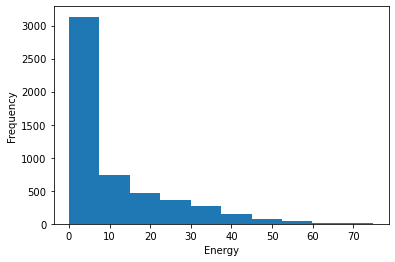

In [6]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel('Energy')
ax1.set_ylabel('Frequency')

Before starting to make predictions, let's create a function that to train a neural network. Let's also create functions to split the data and to print the error metrics and plot the predicted values against the observed values.

In [7]:
def make_nn(X_train, y_train, validation_data, n_neurons=(400,400,400), activations='relu'):
    
    # initialization
    if type(activations) is str:
        activations = [activations] * len(n_neurons)
           
    # set model
    model = Sequential()
    for i, (n_neurons_, activation) in enumerate(zip(n_neurons, activations)):
        model.add(Dense(n_neurons_, activation=activation))
    model.add(Dense(1))
    
    # set optimizer
    optimizer = optimizers.Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    
    # set early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=10.0, patience=10)
    
    # fit the model
    history = model.fit(X_train, y_train, epochs=1000, batch_size=1000, validation_data=validation_data)
                    
    return model, history

In [8]:
def split_data(X, y, train_size):
    
    # split data
    test_size = 1 - train_size
    indices = range(len(y))
    X_train = X[indices[:-int(round(len(indices) * test_size))]]
    X_test = X[indices[-int(round(len(indices) * test_size)):]]
    y_train = y[indices[:-int(round(len(indices) * test_size))]]
    y_test = y[indices[-int(round(len(indices) * test_size)):]]
    
    return (X_train, X_test, y_train, y_test)

In [9]:
def evaluate_model(model, X_test, y_test, n_train):
    
    # predict test
    y_pred = model.predict(X_test)

    # error metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    expl_var = explained_variance_score(y_test, y_pred)
    print("The mean squared error is %0.3e" % mse)
    print("The R2 score is %0.3f" % r2)
    print("The explained variance score is %0.3f" % expl_var)

    # plot predicted vs observed
    plt.figure()
    plt.plot(y_test, y_pred, 'o')
    plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'r-')
    plt.title('$n_{train} = %i$, $R^{2} = %0.3f$, $ MSE = %0.3e$' % (n_train, r2, mse))
    plt.ylabel("Predicted")
    plt.xlabel("Observed")
    plt.show()

So, let's split the data and start to make some predictions!

In [10]:
# split data
train_size = .1
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
model, history = make_nn(X_train_scaled, y_train, (X_test_scaled, y_test))

Epoch 1/1000
1/1 [==============================] - 0s 230ms/step - loss: 264.3628 - val_loss: 287.0848
Epoch 2/1000
1/1 [==============================] - 0s 81ms/step - loss: 263.5728 - val_loss: 286.2700
Epoch 3/1000
1/1 [==============================] - 0s 76ms/step - loss: 262.7834 - val_loss: 285.4542
Epoch 4/1000
1/1 [==============================] - 0s 79ms/step - loss: 261.9940 - val_loss: 284.6367
Epoch 5/1000
1/1 [==============================] - 0s 82ms/step - loss: 261.2032 - val_loss: 283.8158
Epoch 6/1000
1/1 [==============================] - 0s 79ms/step - loss: 260.4087 - val_loss: 282.9906
Epoch 7/1000
1/1 [==============================] - 0s 75ms/step - loss: 259.6109 - val_loss: 282.1610
Epoch 8/1000
1/1 [==============================] - 0s 77ms/step - loss: 258.8083 - val_loss: 281.3265
Epoch 9/1000
1/1 [==============================] - 0s 77ms/step - loss: 257.9999 - val_loss: 280.4857
Epoch 10/1000
1/1 [==============================] - 0s 74ms/step - loss

The neural network evolves as follows:

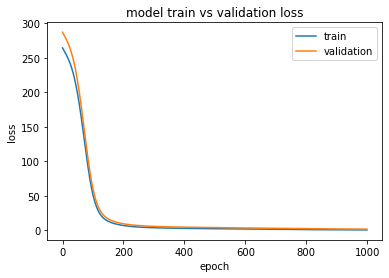

In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

And these are the evaluation metrics:

The mean squared error is 1.752e+00
The R2 score is 0.990
The explained variance score is 0.990


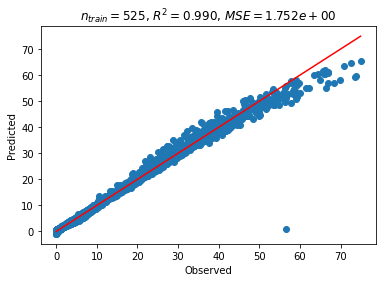

In [12]:
evaluate_model(model, X_test_scaled, y_test, n_train)

Let's now use more data and see what happens.

Epoch 1/1000
5/5 [==============================] - 0s 42ms/step - loss: 280.6480 - val_loss: 294.2847
Epoch 2/1000
5/5 [==============================] - 0s 26ms/step - loss: 277.5306 - val_loss: 291.0163
Epoch 3/1000
5/5 [==============================] - 0s 29ms/step - loss: 274.3756 - val_loss: 287.5703
Epoch 4/1000
5/5 [==============================] - 0s 25ms/step - loss: 270.9173 - val_loss: 283.6952
Epoch 5/1000
5/5 [==============================] - 0s 26ms/step - loss: 267.0710 - val_loss: 279.1404
Epoch 6/1000
5/5 [==============================] - 0s 27ms/step - loss: 262.4193 - val_loss: 273.6903
Epoch 7/1000
5/5 [==============================] - 0s 27ms/step - loss: 256.9223 - val_loss: 267.1311
Epoch 8/1000
5/5 [==============================] - 0s 25ms/step - loss: 250.2333 - val_loss: 259.3318
Epoch 9/1000
5/5 [==============================] - 0s 25ms/step - loss: 242.4399 - val_loss: 250.2087
Epoch 10/1000
5/5 [==============================] - 0s 24ms/step - loss:

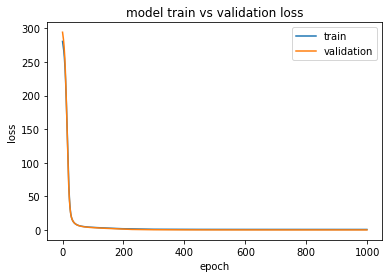

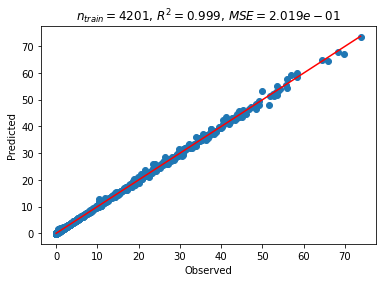

In [13]:
# split data
train_size = .8
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
model, history = make_nn(X_train_scaled, y_train, (X_test_scaled, y_test))

# evolution
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# results
evaluate_model(model, X_test_scaled, y_test, n_train)

Let's define function to plot the outputs.

In [14]:
def make_reg_plot(scaler, reg, variables, x3, labels, bounds):

    column_names = [col for col in points.columns]

    indices =  [column_names.index(name) for name in variables]

    xx = np.meshgrid(np.arange(bounds[0][0], bounds[0][1], 0.02),
                          np.arange(bounds[1][0], bounds[1][1], 0.02))

    n = len(xx[0].ravel())
    xx.append(x3 * np.ones(n))

    XX = np.empty((n, 3))
    for index, xx_ in zip(indices, xx):
        XX[:, index] = xx_.ravel()

    XX_scaled = scaler.transform(XX)

    Y = reg.predict(XX_scaled)
    Y = Y.reshape(xx[0].shape)

    # plot
    fig, ax = plt.subplots()
    cs = ax.contourf(xx[0], xx[1], Y, alpha=0.8, cmap=plt.get_cmap('jet'))
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title('%s = %.2g' % (labels[2], x3))
    fig.colorbar(cs)

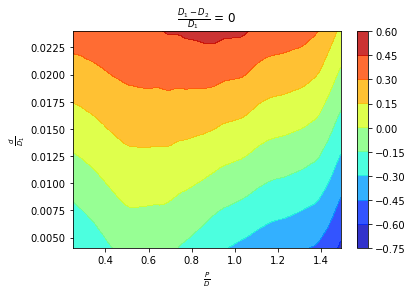

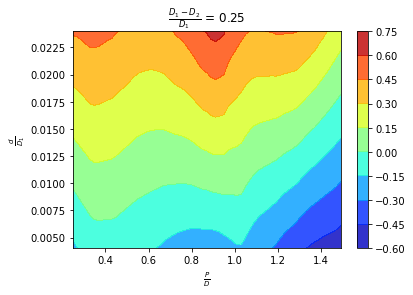

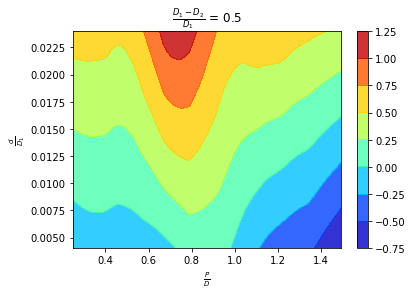

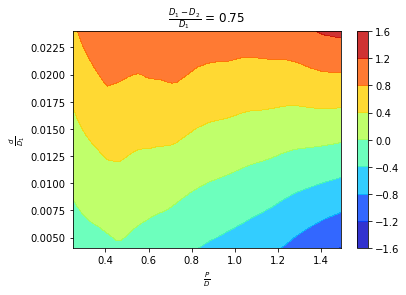

In [15]:
variables = ['ratio_pitch', 'ratio_d', 'ratio_top_diameter']
labels = ['$\\frac{P}{D}$', '$\\frac{d}{D_1}$', '$\\frac{D_1 - D_2}{D_1}$']
bounds = [data['doe_variables'][name] for name in variables]
bounds[1] = [0.004, 0.025]

for x3 in [0., 0.25, 0.5, 0.75]:
    make_reg_plot(scaler, model, variables, x3, labels, bounds)